This notebook describes the steps performed to create the product corresponding to the specific species defined by Olivier.

In [1]:
using DIVAnd
using PyPlot
using NCDatasets
using Missings
using Interpolations

if VERSION >= v"0.7"
    using Random
    using DelimitedFiles
    using Statistics
    using Printf
    using FileIO
else
    using Compat: @info, @warn, range, cat
end

In [23]:
# Module where the output grid and the modules are defined
include("../src/make_fishs_products.jl");

In [28]:
datafile = joinpath(datadir, "FishSpecific/Fish_Specific_cases.csv");
outputfile = joinpath(outputdirFish, replace(basename(datafile), ".csv" => ".nc"))

"../output/fish/Fish_Specific_cases.nc"

## Prepare the grid and the mask

In [13]:
# Grid stored in emodnet_bio_grid.jl
xi,yi = DIVAnd.ndgrid(gridlonFish, gridlatFish);

# Mask
topodir = "../data/"
topofile = joinpath(topodir, "gebco_30sec_8.nc");

if isfile(topofile)
    bx, by, b = DIVAnd.load_bath(topofile,true,gridlonFish, gridlatFish);
    xmask, ymask, mmask = DIVAnd.load_mask(topofile,true,gridlonFish, gridlatFish,[0]);
else
    @error "Bathymetry file doesn't exist"
end
mmask = mmask[:,:,1]
@info size(mmask)

# Metrics
pm = ones(size(xi)) / (xi[2,1]-xi[1,1]);
pn = ones(size(xi)) / (yi[1,2]-yi[1,1]);

┌ Info: (391, 261)
└ @ Main In[13]:15


## Read data

@info "Reading data file $(datafile)"
obslon, obslat, g1, g2, g3, g4 = read_fish_specific(datafile);
@info extrema(obslat)
@info extrema(obslon) 
@info extrema(gridlonFish)
@info extrema(gridlatFish) 

### Make plot

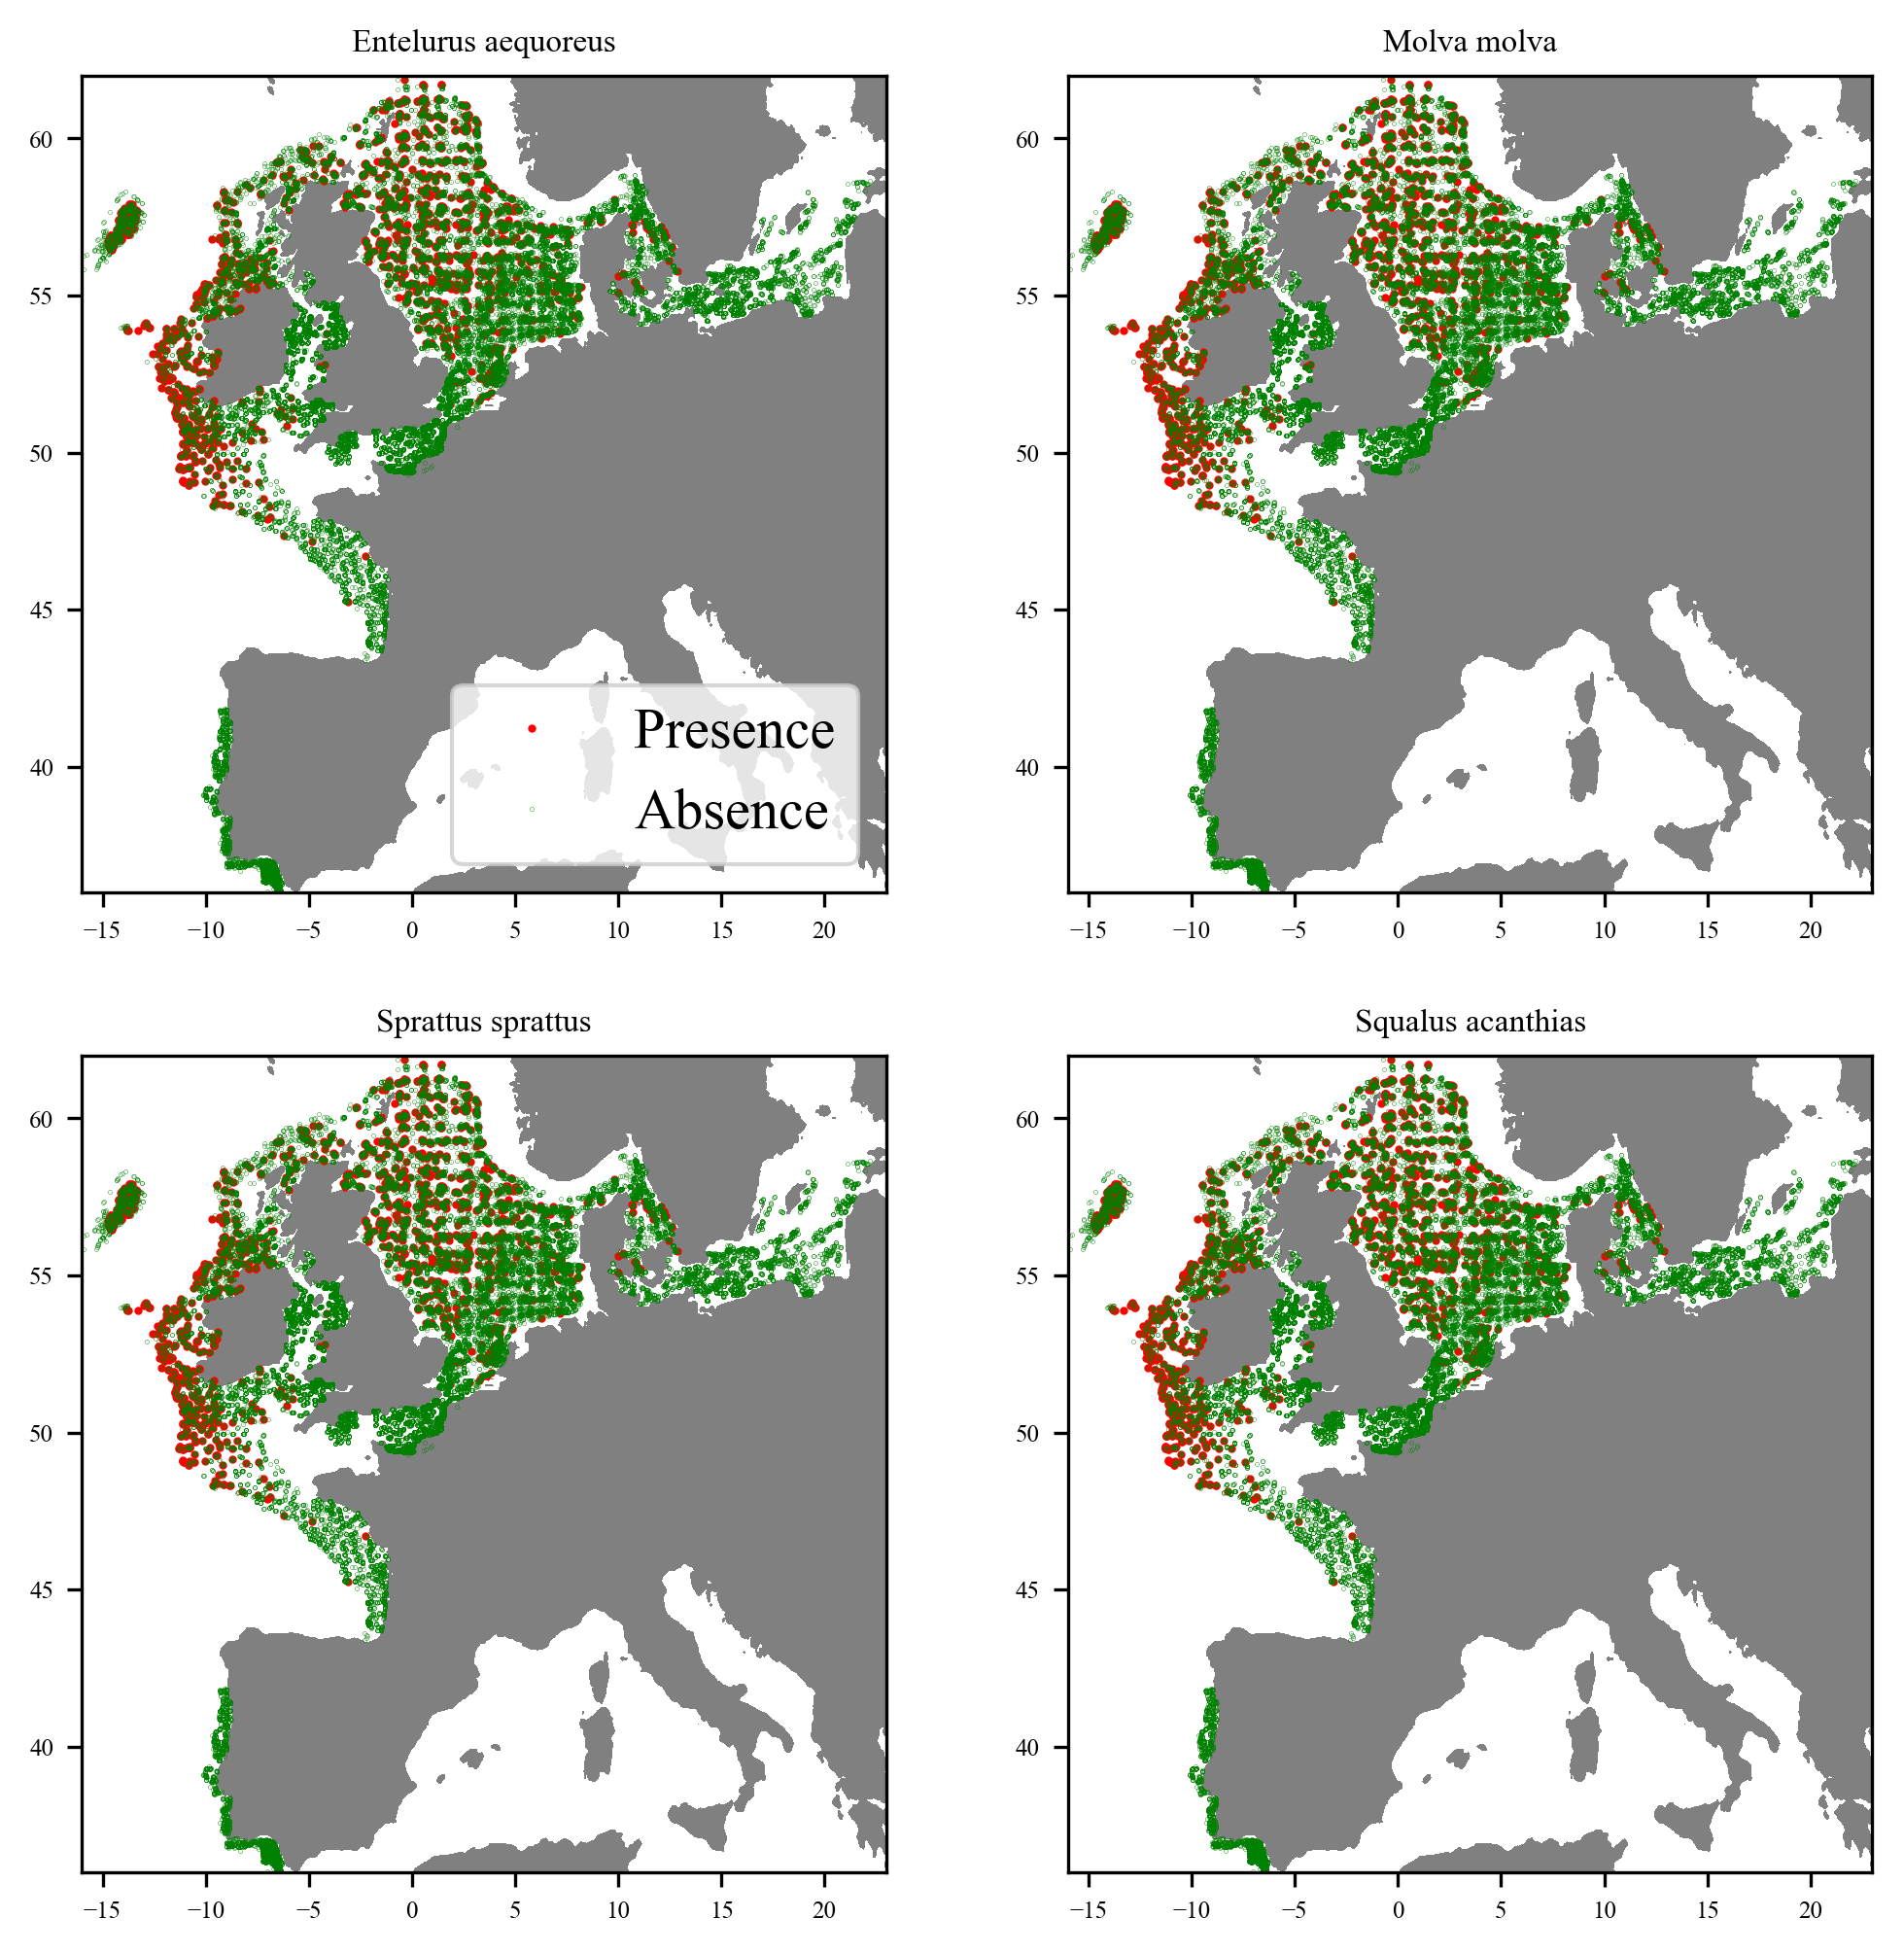

In [18]:
make_scatter_grid_specific_fish([g1, g2, g3, g4], 
    ["Entelurus aequoreus","Molva molva","Sprattus sprattus","Squalus acanthias"])
PyPlot.savefig(joinpath(figdirFish, "Fish_Specific_cases_data.png"), 
    dpi=300, bbox_inches="tight")

## Parameter choice 
Chose via sensitivity analysis, as the optimisation tools provide too low values for L and noise-to-signal ratio.

In [19]:
# Correlation length
len = 4.;
# Observational error variance normalized by the background error variance
epsilon2 = 10.;

The weight is decreased for very close points.

In [20]:
rdiag=1.0./DIVAnd.weight_RtimesOne((obslon, obslat),(0.03,0.03))
@show maximum(rdiag),mean(rdiag);
epsilon2 = epsilon2*rdiag;

(maximum(rdiag), mean(rdiag)) = (34.37624664581305, 7.778784558619619)


## Perform analysis

In [21]:
🐟1, 🐟2, 🐟3, 🐟4 = make_fish_analysis(obslon, obslat, g1, g2, g3, g4);

  0.898409 seconds (1.72 M allocations: 998.774 MiB, 35.24% gc time)
  0.837628 seconds (1.72 M allocations: 998.738 MiB, 34.43% gc time)
  0.852236 seconds (1.72 M allocations: 998.738 MiB, 35.09% gc time)
  0.915721 seconds (1.72 M allocations: 998.738 MiB, 34.42% gc time)


### Make plots

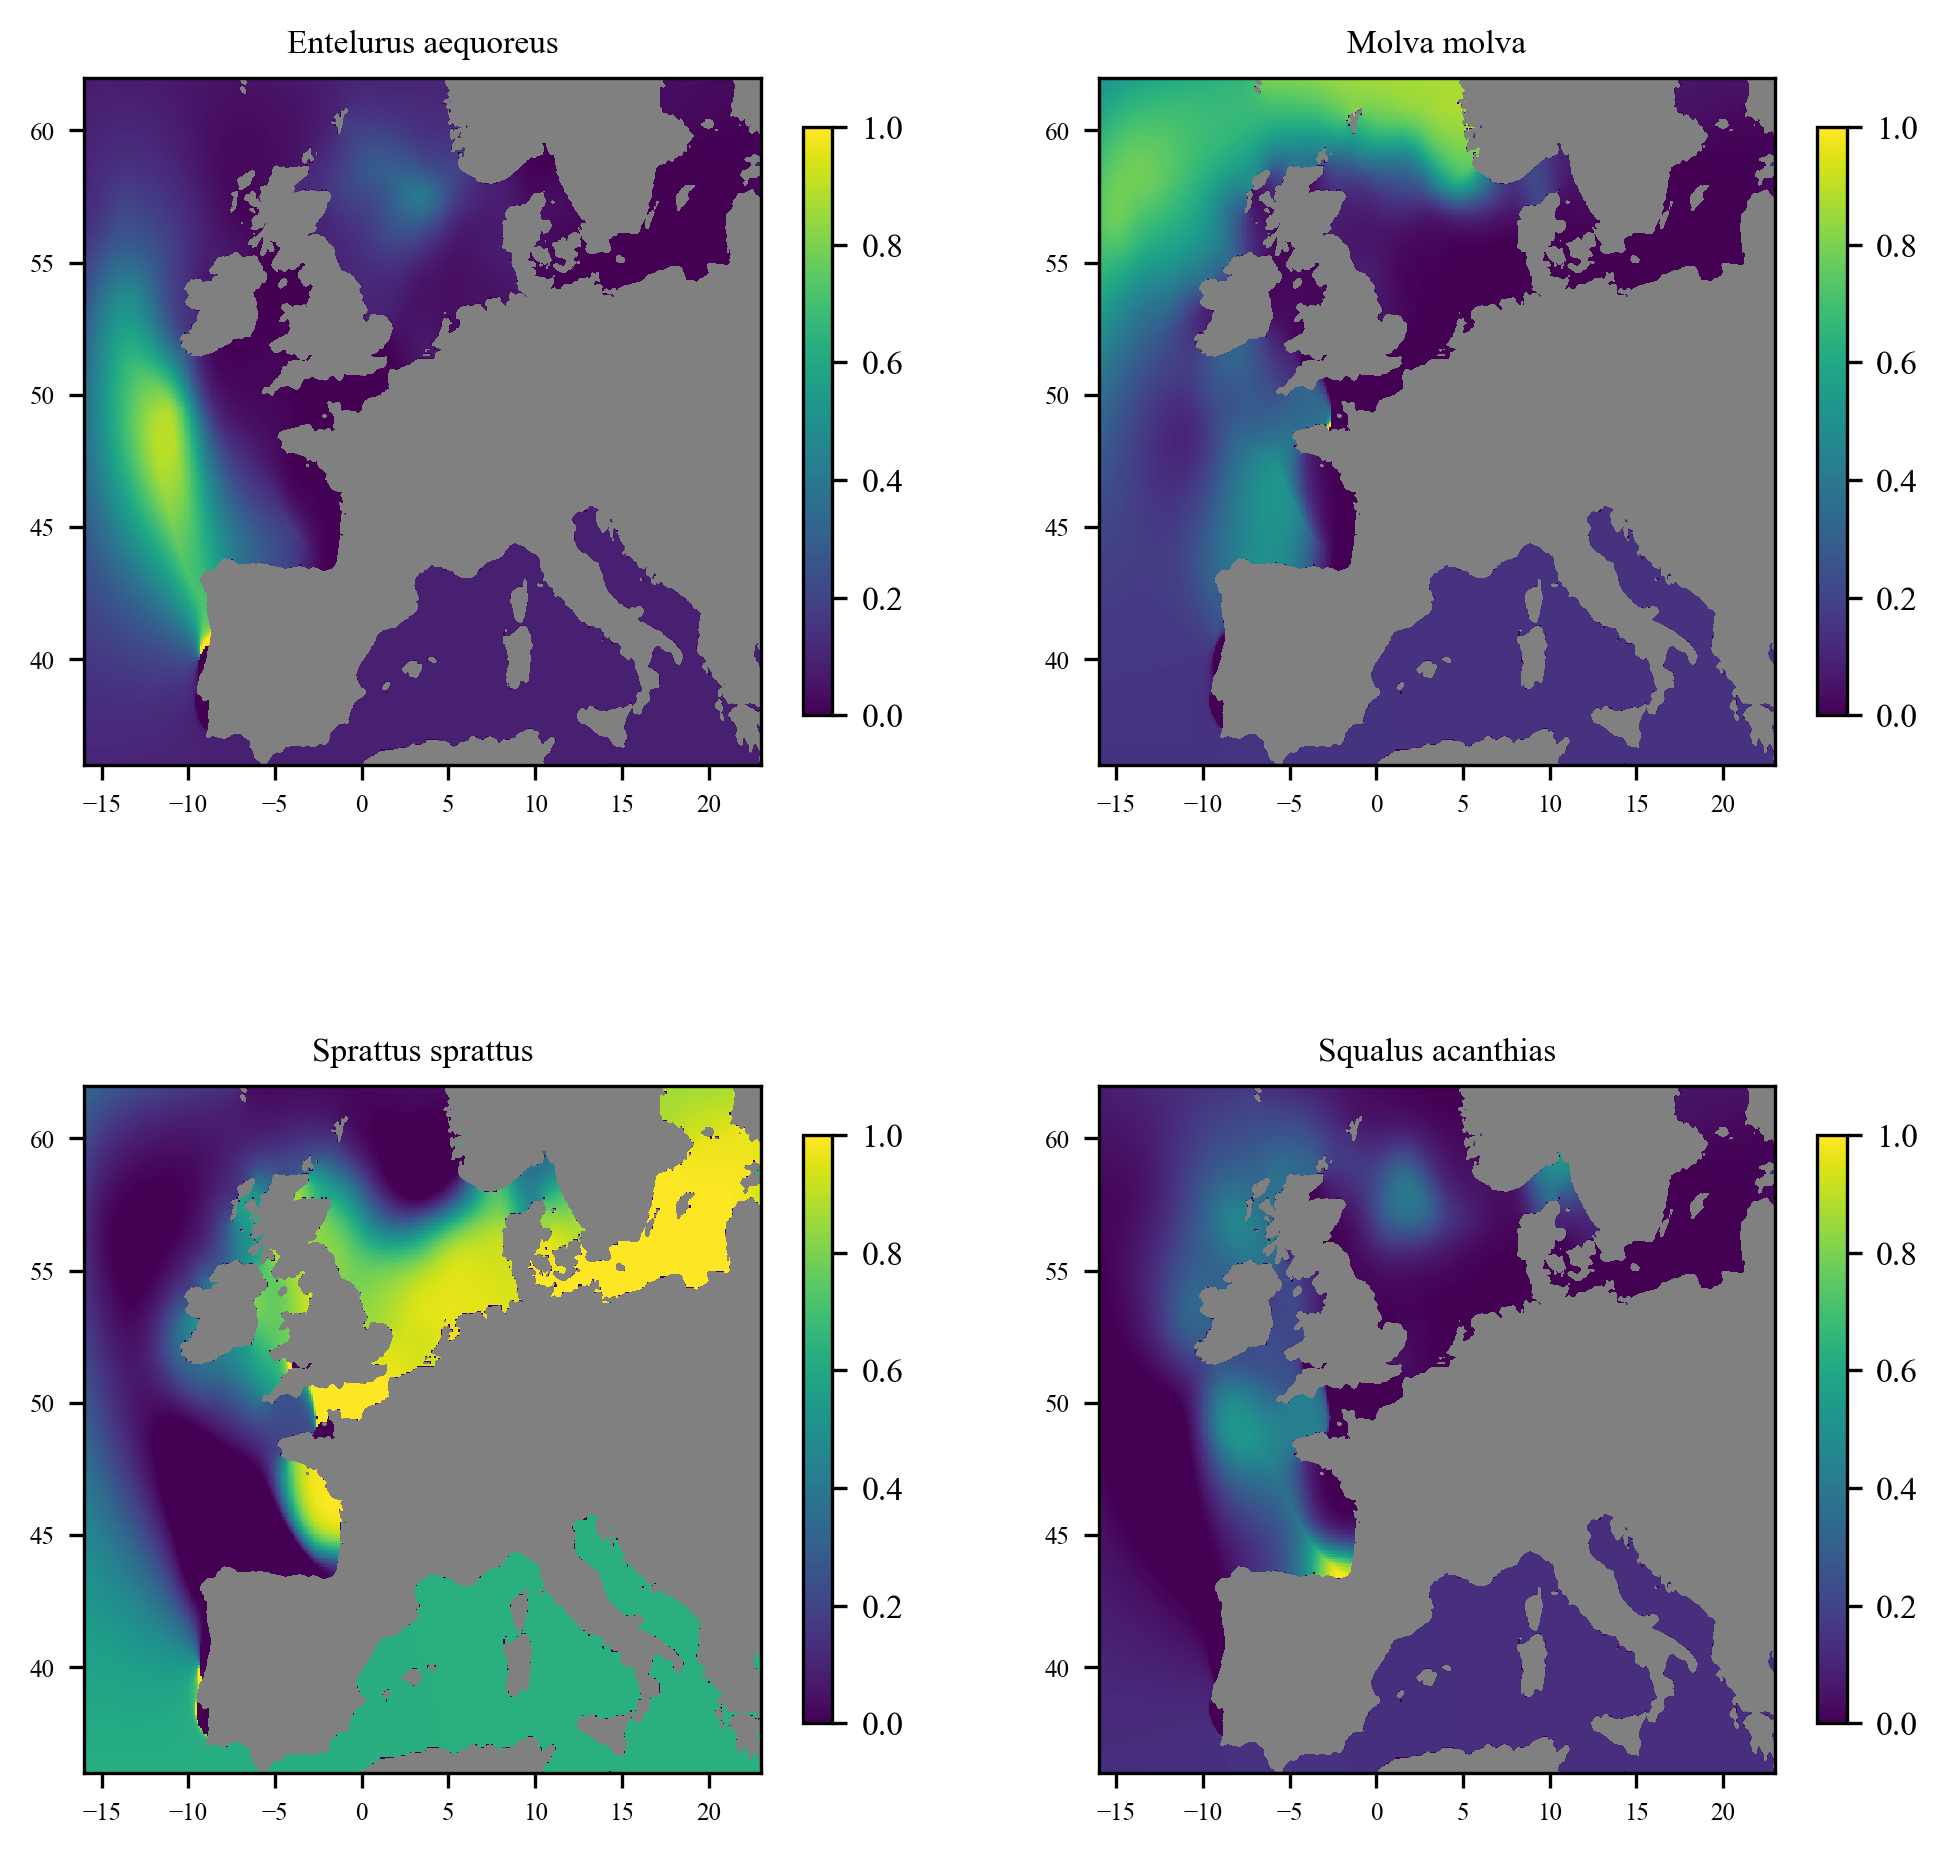

In [26]:
make_scatter_grid_specific_fish([🐟1, 🐟2, 🐟3, 🐟4 ], 
    ["Entelurus aequoreus","Molva molva","Sprattus sprattus","Squalus acanthias"])
PyPlot.savefig(joinpath(figdirFish, "Fish_Specific_cases_field.png"), 
    dpi=300, bbox_inches="tight")

### Error fields

In [22]:
🐟1_err, 🐟2_err, 🐟3_err, 🐟4_err = compute_fish_error(obslon, obslat, g1, g2, g3, g4);

### Make plots

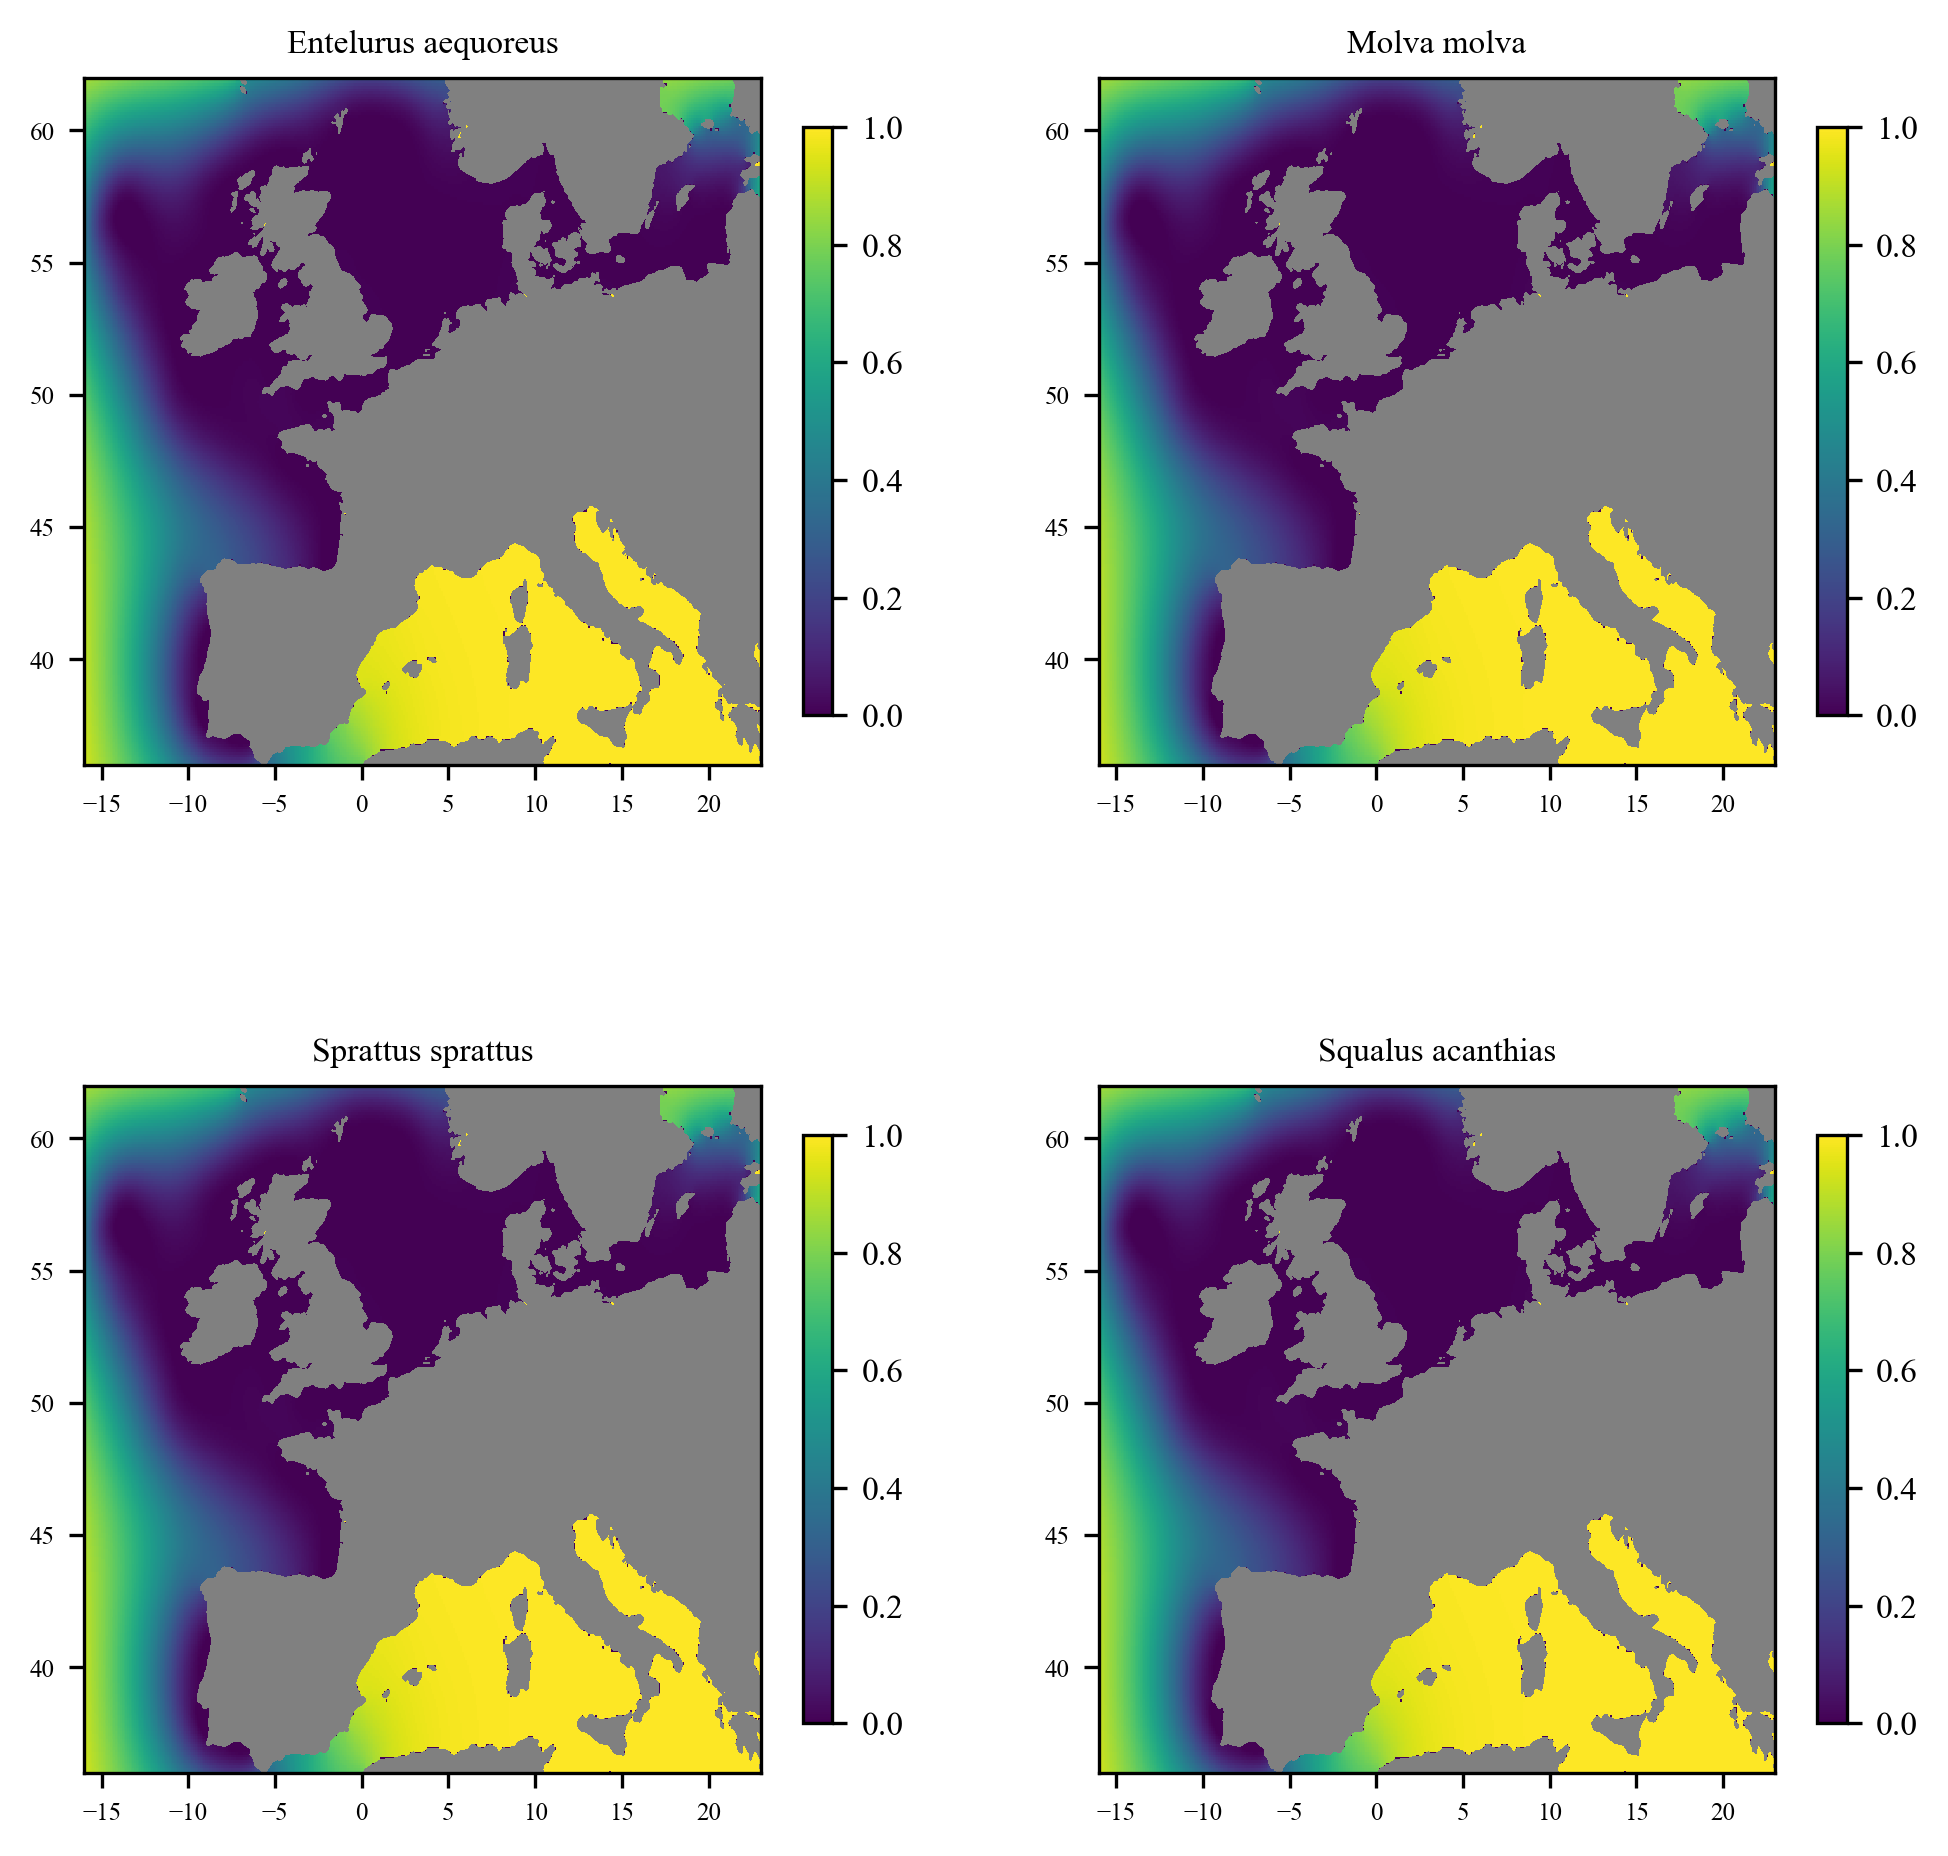

In [27]:
make_scatter_grid_specific_fish([🐟1_err, 🐟2_err, 🐟3_err, 🐟4_err], 
    ["Entelurus aequoreus","Molva molva","Sprattus sprattus","Squalus acanthias"])
PyPlot.savefig(joinpath(figdirFish, "Fish_Specific_cases_error.png"), 
    dpi=300, bbox_inches="tight")

## Write the results and the error field in a netCDF file
Create new output directory if necessary.

In [31]:
@info "Write netCDF file $(outputfile)"
write_fish_specific_nc(outputfile, gridlonFish, gridlatFish,
    🐟1, 🐟2, 🐟3, 🐟4, 🐟1_err, 🐟2_err, 🐟3_err, 🐟4_err);

┌ Info: Write netCDF file ../output/fish/Fish_Specific_cases.nc
└ @ Main In[31]:1
